In [116]:
import csv
import numpy as np
import collections
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import functools
from matplotlib import pylab
import math
%matplotlib inline

In [117]:
data = []
counter = 0
with open('train_data.csv', 'r') as f:
    reader = csv.DictReader(f)
    for i,row in enumerate(reader):
        if not row['off'] and not row['def']:
            print(i, row)
            counter += 1
        data.append(row)
print(counter)

0


In [118]:
grouped_by_game = collections.defaultdict(list)
for line in data:
    grouped_by_game[line['gameid']].append(line)
grouped_by_game = list(grouped_by_game.values())

In [119]:
for game in grouped_by_game:
    for play_dict in game:
        for key in play_dict:
            try:
                play_dict[key] = int(play_dict[key])
            except:
                pass

In [120]:
for game in grouped_by_game:
    game.sort(key = lambda x: -int(x['time']))

In [121]:
if 0:
    total_average_yardage = []
    moving_average = []
    num_plays_before_calc = 3
    for game in grouped_by_game:
        num_total_yards = (0, 0)
        num_plays = (0, 0)
        yard_per_play=[]
        first_team_yards=0
        first_team_plays=0
        second_team_yards=0
        second_team_plays=0

        for i in range(len(game)-1):
            play_dict = game[i]
            alph_first_team = play_dict['off'] if play_dict['off']<play_dict['def'] else play_dict['def']
            next_play_dict = game[i+1]
            if next_play_dict['down'] is not None and play_dict['down'] is not None and play_dict['ydline'] !='' and next_play_dict['ydline'] !='' and next_play_dict['off']==play_dict['off'] and next_play_dict['description'].find('punt')==-1:
                progress = play_dict['ydline']-next_play_dict['ydline']
                if play_dict['off']==alph_first_team:
                    first_team_yards+=progress
                    first_team_plays+=1
                    if first_team_plays>num_plays_before_calc:
                        moving_average.append(first_team_yards/first_team_plays)
                else:
                    second_team_yards+=progress
                    second_team_plays+=1
                    if second_team_plays>num_plays_before_calc:
                        moving_average.append(second_team_yards/second_team_plays)
                yard_per_play.append(progress)

        total_average_yardage.append(first_team_yards/first_team_plays)
        total_average_yardage.append(second_team_yards/second_team_plays)

In [122]:
if 0:
    total_average_yardage = np.array(total_average_yardage).reshape(len(total_average_yardage), 1)
    moving_average = np.array(moving_average).reshape(len(moving_average), 1)

In [123]:
if 0:
    plt.hist(moving_average, 100)
    plt.show()

In [124]:
if 0:
    for i,game in enumerate(grouped_by_game):
        first_team_yards=0.0
        first_team_plays=0.0
        second_team_yards=0.0
        second_team_plays=0.0
        for j,play_dict in enumerate(game):
            if j < len(game)-1:
                alph_first_team = play_dict['off'] if play_dict['off']<play_dict['def'] else play_dict['def']
                next_play_dict = game[j+1]
                if next_play_dict['down'] is not None and play_dict['down'] is not None and play_dict['ydline'] !='' and next_play_dict['ydline'] !='' and next_play_dict['off']==play_dict['off'] and next_play_dict['description'].find('punt')==-1:
                    progress = play_dict['ydline']-next_play_dict['ydline']
                    if play_dict['off']==alph_first_team:
                        first_team_yards+=progress
                        first_team_plays+=1
                        play_dict['avg_yards'] = first_team_yards/first_team_plays
                        play_dict['num_plays_exec'] = first_team_plays
                    else:
                        second_team_yards+=progress
                        second_team_plays+=1
                        play_dict['avg_yards'] = second_team_yards/second_team_plays 
                        play_dict['num_plays_exec'] = second_team_plays
                else: #if yards didn't change/it was not a standard play (i.e. field goal)
                    if play_dict['off']==alph_first_team and first_team_plays>0:
                        play_dict['avg_yards'] = first_team_yards/first_team_plays
                        play_dict['num_plays_exec'] = first_team_plays
                    elif second_team_plays>0:
                        play_dict['avg_yards'] = second_team_yards/second_team_plays
                        play_dict['num_plays_exec'] = second_team_plays

In [125]:
if 0:    
    twenty_perecentile = np.percentile(moving_average, 20)
    forty_percentile = np.percentile(moving_average, 40)
    sixty_percentile = np.percentile(moving_average, 60)
    eighty_percentile = np.percentile(moving_average, 80)

In [126]:
def put_into_bucket(play_dict):
    yard = play_dict['ydline'] // 50
    down = play_dict['down']
    #if play_dict['togo'] <= 5:
    #    togo = 0
    if play_dict['togo'] <= 10:
        togo = 1
    else:
        togo = 2
    '''if play_dict['togo'] <= 2:
        togo = 0
    elif play_dict['togo'] <= 4:
        togo = 1
    elif play_dict['togo'] <= 6:
        togo = 2
    elif play_dict['togo'] <= 8:
        togo = 3
    elif play_dict['togo'] <= 10:
        togo = 4
    elif play_dict['togo'] <= 15:
        togo = 5
    elif play_dict['togo'] <= 20:
        togo = 6
    else:
        togo = 7'''
    #average yardage
    '''
    if play_dict['avg_yards'] <= twenty_perecentile:
        avg_yards = 1
    elif play_dict['avg_yards'] <= forty_percentile:
        avg_yards = 2
    elif play_dict['avg_yards'] <= sixty_percentile:
        avg_yards = 3
    elif play_dict['avg_yards'] <= eighty_percentile:
        avg_yards = 4
    else:
        avg_yards = 5
    '''
    if play_dict['off'] < play_dict['def']:
        posession = 1
    else:
        posession = 0
    #return (1, 1, 1, posession)
    return (yard,down,togo, posession)
    #return (yard, down, togo, avg_yards, posession)

In [127]:
def group_by_score_change(game, original_scores = None):
    if not game:
        return []
    if original_scores is None:
        original_scores = collections.defaultdict(int)
    changed_team = None
    changed_score = None
    for i, play in enumerate(game):
        if original_scores[play['off']] != play['offscore']:
            changed_team = play['off']
            changed_score = play['offscore'] - original_scores[changed_team]
            break
        if original_scores[play['def']] != play['defscore']:
            changed_team = play['def']
            changed_score = play['defscore'] - original_scores[changed_team]
            break     
    
    if changed_team is None:
        return [('', 0,game)]
    
    new_scores = collections.defaultdict(int)
    new_scores[play['off']] = play['offscore']
    new_scores[play['def']] = play['defscore']
    return [(changed_team, changed_score, game[:i+1])] + group_by_score_change(game[i+1:], new_scores)    

In [128]:
def bucketable(play):
    if not play['down']:
        return False
    if play['down'] < 1:
        return False
    if play['down'] > 4:
        return False
    if not play['togo']:
        return False
    if play['togo'] < 1:
        return False
    if not play['ydline']:
        return False
    if play['ydline'] < 1:
        return False
    if not play['off'] or not play['def']:
        return False
    
    #if 'num_plays_exec' not in play or play['num_plays_exec'] <= 3:
    #    return False
    
    return True
    


In [129]:
def possession(play):
    if play_dict['off'] < play_dict['def']:
        return 1
    else:
        return 0

def bucket_group(group):
    global test
    test = group
    team, diff, group = group
    answer = []
    teams = set()

    for play in group:
        teams.add(play['off'])
        teams.add(play['def'])
    if '' in teams:
        teams.remove('')
    if team:
        #print(teams)
        pos = 1 - sorted(teams).index(team)
    
    if diff != 0:
        group2 = group[:-1]
    else:
        group2 = group
    for i, play in enumerate(group2):
        if play['time'] in (1800, 3600):
            if i == 0 or group2[i-1]['time'] in (1800, 3600):
                answer.append([6])
        if bucketable(play):
            answer.append(put_into_bucket(play))
        else:
            answer.append([6])
            
    
        
    if team:

        if answer and answer[-1] == [6]:
            answer = answer[:-1]
        if diff == 2:
            answer.append([1, pos])
            answer.append([5, 1-pos])
        elif diff == 3:
            answer.append([0, pos])
            answer.append([5, pos])
        elif diff == 6:
            answer.append([2, pos])
            answer.append([5, pos])
        elif diff == 7:
            answer.append([2, pos])
            answer.append([3, pos])
            answer.append([5, pos])
        elif diff == 8:
            answer.append([2, pos])
            answer.append([4, pos])
            answer.append([5, pos])
        elif diff != 0:
            answer.append([6])
        '''
        play_dict = group[-1]
        if 'avg_yards' in play_dict:
            if play_dict['avg_yards'] <= twenty_perecentile:
                avg_yards = 1
            elif play_dict['avg_yards'] <= forty_percentile:
                avg_yards = 2
            elif play_dict['avg_yards'] <= sixty_percentile:
                avg_yards = 3
            elif play_dict['avg_yards'] <= eighty_percentile:
                avg_yards = 4
            else:
                avg_yards = 5
            if answer and answer[-1] == [6]:
                answer = answer[:-1]
            if diff == 2:
                answer.append([1, avg_yards, pos])
                answer.append([5, avg_yards, 1-pos])
            elif diff == 3:
                answer.append([0, avg_yards, pos])
                answer.append([5, avg_yards, pos])
            elif diff == 6:
                answer.append([2, avg_yards, pos])
                answer.append([5, avg_yards, pos])
            elif diff == 7:
                answer.append([2, avg_yards, pos])
                answer.append([3, avg_yards, pos])
                answer.append([5, avg_yards, pos])
            elif diff == 8:
                answer.append([2, avg_yards, pos])
                answer.append([4, avg_yards, pos])
                answer.append([5, avg_yards, pos])
            elif diff != 0:
                answer.append([6])'''
    return answer
        

In [130]:
def bucket_game(game):
    grouped = group_by_score_change(game)
    answer = []
    for group in grouped:
        answer += bucket_group(group)
    return answer
        


In [131]:
bucket_game(grouped_by_game[0])

[(1, 1, 1, 1),
 (1, 2, 1, 1),
 (1, 3, 1, 1),
 (1, 1, 1, 1),
 (1, 2, 1, 1),
 (1, 3, 2, 1),
 (1, 4, 2, 1),
 (1, 1, 1, 0),
 (1, 2, 1, 0),
 (1, 2, 1, 0),
 (1, 1, 1, 0),
 (1, 2, 1, 0),
 (1, 3, 1, 0),
 (1, 4, 1, 0),
 (1, 4, 2, 0),
 (1, 1, 1, 1),
 (1, 1, 1, 1),
 (1, 2, 1, 1),
 (1, 3, 1, 1),
 (0, 1, 1, 1),
 (0, 2, 1, 1),
 (0, 3, 1, 1),
 (0, 1, 1, 1),
 (0, 1, 1, 1),
 [2, 1],
 [3, 1],
 [5, 1],
 (1, 1, 1, 0),
 (1, 2, 1, 0),
 (1, 3, 1, 0),
 (1, 4, 1, 0),
 (1, 1, 1, 1),
 (1, 2, 1, 1),
 (1, 3, 1, 1),
 (1, 1, 1, 1),
 (1, 1, 2, 1),
 (1, 2, 2, 1),
 (1, 2, 2, 1),
 (1, 3, 1, 1),
 (1, 1, 1, 1),
 (1, 2, 1, 1),
 (0, 1, 1, 1),
 (0, 1, 1, 1),
 (0, 2, 1, 1),
 (1, 1, 1, 0),
 (1, 2, 1, 0),
 (1, 3, 1, 0),
 (1, 3, 2, 0),
 (1, 4, 2, 0),
 (1, 1, 1, 1),
 (1, 2, 1, 1),
 (0, 1, 1, 1),
 (0, 1, 2, 1),
 (0, 1, 2, 1),
 (0, 2, 2, 1),
 (0, 3, 2, 1),
 (0, 4, 2, 1),
 (1, 1, 1, 0),
 (1, 1, 1, 0),
 (1, 2, 1, 0),
 (1, 3, 1, 0),
 (0, 4, 1, 0),
 (1, 1, 1, 1),
 (1, 2, 2, 1),
 (1, 3, 1, 1),
 [2, 1],
 [3, 1],
 [5, 1],
 (1, 1, 1, 0),
 

In [132]:
bucket_sequence = []
for game in grouped_by_game:
    bucket_sequence += bucket_game(game)
    bucket_sequence += [6]

In [133]:
buckets = bucket_sequence #glue scripts together
len(buckets)

441183

In [134]:
for i in range(len(buckets)):
    if buckets[i] == 6:
        buckets[i] = [6]
    buckets[i] = list(buckets[i])

In [135]:
buckets[:100]

[[1, 1, 1, 1],
 [1, 2, 1, 1],
 [1, 3, 1, 1],
 [1, 1, 1, 1],
 [1, 2, 1, 1],
 [1, 3, 2, 1],
 [1, 4, 2, 1],
 [1, 1, 1, 0],
 [1, 2, 1, 0],
 [1, 2, 1, 0],
 [1, 1, 1, 0],
 [1, 2, 1, 0],
 [1, 3, 1, 0],
 [1, 4, 1, 0],
 [1, 4, 2, 0],
 [1, 1, 1, 1],
 [1, 1, 1, 1],
 [1, 2, 1, 1],
 [1, 3, 1, 1],
 [0, 1, 1, 1],
 [0, 2, 1, 1],
 [0, 3, 1, 1],
 [0, 1, 1, 1],
 [0, 1, 1, 1],
 [2, 1],
 [3, 1],
 [5, 1],
 [1, 1, 1, 0],
 [1, 2, 1, 0],
 [1, 3, 1, 0],
 [1, 4, 1, 0],
 [1, 1, 1, 1],
 [1, 2, 1, 1],
 [1, 3, 1, 1],
 [1, 1, 1, 1],
 [1, 1, 2, 1],
 [1, 2, 2, 1],
 [1, 2, 2, 1],
 [1, 3, 1, 1],
 [1, 1, 1, 1],
 [1, 2, 1, 1],
 [0, 1, 1, 1],
 [0, 1, 1, 1],
 [0, 2, 1, 1],
 [1, 1, 1, 0],
 [1, 2, 1, 0],
 [1, 3, 1, 0],
 [1, 3, 2, 0],
 [1, 4, 2, 0],
 [1, 1, 1, 1],
 [1, 2, 1, 1],
 [0, 1, 1, 1],
 [0, 1, 2, 1],
 [0, 1, 2, 1],
 [0, 2, 2, 1],
 [0, 3, 2, 1],
 [0, 4, 2, 1],
 [1, 1, 1, 0],
 [1, 1, 1, 0],
 [1, 2, 1, 0],
 [1, 3, 1, 0],
 [0, 4, 1, 0],
 [1, 1, 1, 1],
 [1, 2, 2, 1],
 [1, 3, 1, 1],
 [2, 1],
 [3, 1],
 [5, 1],
 [1, 1, 1, 0],
 

In [136]:
buckets[96][:-1]

[1, 1, 1]

In [137]:
counts = collections.defaultdict(collections.Counter)
for i in range(len(buckets) - 1):
    if buckets[i] != [6] and buckets[i+1] != [6]:
        start = buckets[i][:-1]
        end = buckets[i+1][:-1]
        if buckets[i][-1] == buckets[i+1][-1]:
            end.append(0)
        else:
            end.append(1)
    
        counts[tuple(start)][tuple(end)] += 1

In [138]:
#remove states we can't support
counter = 0
updated = True
while updated:
    updated = False
    for bucket_start in counts:
        for bucket_end in counts[bucket_start]:
            end = list(bucket_end)[:-1]
            if tuple(end) not in counts and counts[bucket_start][bucket_end]:
                print(bucket_start, bucket_end)
                counts[bucket_start][bucket_end] = 0
                counter += 1
                updated = True
    
print(counter)

(1, 3, 2) (2, 4, 1, 1)
(1, 3, 2) (2, 4, 2, 0)
(1, 3, 1) (2, 4, 1, 1)
(1, 3, 1) (2, 3, 1, 0)
4


In [139]:
buckets[382455: 382460]

[[1, 3, 1, 0], [0, 1, 1, 0], [0, 2, 1, 0], [0, 2, 2, 0], [0, 3, 2, 0]]

In [140]:
for bucket_start in counts:
    if sum(counts[bucket_start].values()) == 0:
        print(bucket_start)
        raise Exception("Hit Guy up to fix")

In [141]:
probabilities = collections.defaultdict(dict)
for bucket_start in counts:
    total = sum(counts[bucket_start].values())
    for bucket_end in counts[bucket_start]:
        if counts[bucket_start][bucket_end]:
            probabilities[bucket_start][bucket_end] = counts[bucket_start][bucket_end] / total

In [142]:
probabilities[(8, 2, 2)]

{}

In [143]:
rewards = collections.defaultdict(int)
rewards[(0,0)] = 3
rewards[(1,0)] = 2
rewards[(2,0)] = 6
rewards[(3,0)] = 1
rewards[(4,0)] = 2
for pair in list(rewards.keys()):
    rewards[(pair[0], 1-pair[1])] = -rewards[pair]
print(rewards)

defaultdict(<class 'int'>, {(0, 1): -3, (2, 0): 6, (0, 0): 3, (3, 0): 1, (1, 0): 2, (3, 1): -1, (4, 1): -2, (1, 1): -2, (2, 1): -6, (4, 0): 2})


In [144]:
THRESHOLD = 10**-8

@functools.lru_cache(maxsize = None)
def predicted_score_difference(current_state, num_turns_left):
    if num_turns_left == 0:
        answer = collections.defaultdict(float)
        answer[rewards[current_state]] = 1.0
        return answer
    
    child_score_diffs = collections.defaultdict(float)
    state,pos = current_state[:-1], current_state[-1]
    for child_state in probabilities[state]:
        p = probabilities[state][child_state]
        #transition to child_state with probability p
        
        child_state = list(child_state)
        child_state[-1] = (pos + child_state[-1]) % 2
        child_state = tuple(child_state)
        child_answer = predicted_score_difference(child_state, num_turns_left - 1)
        for score_diff in child_answer:
            child_score_diffs[score_diff] += p * child_answer[score_diff]
    
    answer = collections.defaultdict(float)
    for score_diff in child_score_diffs:
        if child_score_diffs[score_diff] > THRESHOLD:
            answer[score_diff + rewards[current_state]] = child_score_diffs[score_diff]
    return answer
    

In [145]:
def compute_metrics_for_game(pdf, start_diff, end_diff):
    actual_diff = end_diff - start_diff
    #print(pdf, actual_diff)
    metric2 = math.log(pdf[actual_diff])
    expected_value = 0
    pairs = []
    for diff in pdf:
        pairs.append([pdf[diff], diff])
        expected_value += diff * pdf[diff]
    metric1 = (expected_value - actual_diff) ** 2
    pairs.sort(reverse = True)
    metric3 = 0
    for pair in pairs[:10]:
        if pair[1] == actual_diff:
            metric3 = 1
    return (metric1, metric2, metric3)

In [146]:
test_data = []
with open('formatted_test.csv') as f:
    reader = csv.DictReader(f)
    for line in reader:
        test_data.append(line)

In [147]:
for row in test_data:
    for feature in ('def_team_avg_yards', 'off_team_avg_yards'):
        row[feature] = float(row[feature])
    for feature in ('down', 'final_diff', 'third_diff', 'togo', 'yard_line'):
        row[feature] = int(row[feature])
    

In [148]:
def put_into_bucket_test(play_dict):
    play_dict['ydline'] = play_dict['yard_line']
    play_dict['off'] = 'a'
    play_dict['def'] = 'a'
    if play_dict['yard_line'] == -1 or play_dict['down'] == -1 or play_dict['togo'] == -1:
        return (5,)
    bucket = put_into_bucket(play_dict)
    return bucket[:-1]
    #return (yard, down, togo, avg_yards, posession)
    


In [149]:
metrics = [0,0,0]
for game in test_data:
    start_bucket = tuple(list(put_into_bucket_test(game)) + [0])
    
    pdf = predicted_score_difference(start_bucket, 43)
    for i, metric in enumerate(compute_metrics_for_game(pdf, game['third_diff'], game['final_diff'])):
        metrics[i] += metric

In [150]:
probabilities

defaultdict(dict,
            {(0,): {(5, 0): 1.0},
             (0, 1, 1): {(0, 0): 0.002564790290676233,
              (0, 1, 1, 0): 0.15024977369497436,
              (0, 1, 1, 1): 0.002380393603111275,
              (0, 1, 2, 0): 0.03055956013008348,
              (0, 1, 2, 1): 3.352667046635599e-05,
              (0, 2, 1, 0): 0.6511549937975659,
              (0, 2, 1, 1): 0.00036879337512991586,
              (0, 2, 2, 0): 0.06515908405136286,
              (0, 2, 2, 1): 1.6763335233177994e-05,
              (0, 3, 1, 0): 0.0007208234150266537,
              (0, 3, 1, 1): 1.6763335233177994e-05,
              (0, 3, 2, 0): 0.00015087001709860194,
              (0, 4, 1, 0): 5.029000569953398e-05,
              (1, 0): 1.6763335233177994e-05,
              (1, 1, 1, 0): 0.0004693733865289838,
              (1, 1, 1, 1): 0.016528648539913503,
              (1, 1, 2, 0): 0.008616354309853488,
              (1, 2, 1, 0): 0.0002514500284976699,
              (1, 2, 1, 1): 0.000217923

In [151]:
counts

defaultdict(collections.Counter,
            {(0,): Counter({(5, 0): 7574}),
             (0,
              1,
              1): Counter({(0, 0): 153,
                      (0, 1, 1, 0): 8963,
                      (0, 1, 1, 1): 142,
                      (0, 1, 2, 0): 1823,
                      (0, 1, 2, 1): 2,
                      (0, 2, 1, 0): 38844,
                      (0, 2, 1, 1): 22,
                      (0, 2, 2, 0): 3887,
                      (0, 2, 2, 1): 1,
                      (0, 3, 1, 0): 43,
                      (0, 3, 1, 1): 1,
                      (0, 3, 2, 0): 9,
                      (0, 4, 1, 0): 3,
                      (1, 0): 1,
                      (1, 1, 1, 0): 28,
                      (1, 1, 1, 1): 986,
                      (1, 1, 2, 0): 514,
                      (1, 2, 1, 0): 15,
                      (1, 2, 1, 1): 13,
                      (1, 2, 2, 0): 491,
                      (1, 2, 2, 1): 2,
                      (1, 3, 1, 0): 2,
          

In [152]:
for i in range(3):
    print(metrics[i] / len(test_data))

50.53880779750853
-3.0254012763143785
0.7346938775510204


-35 36


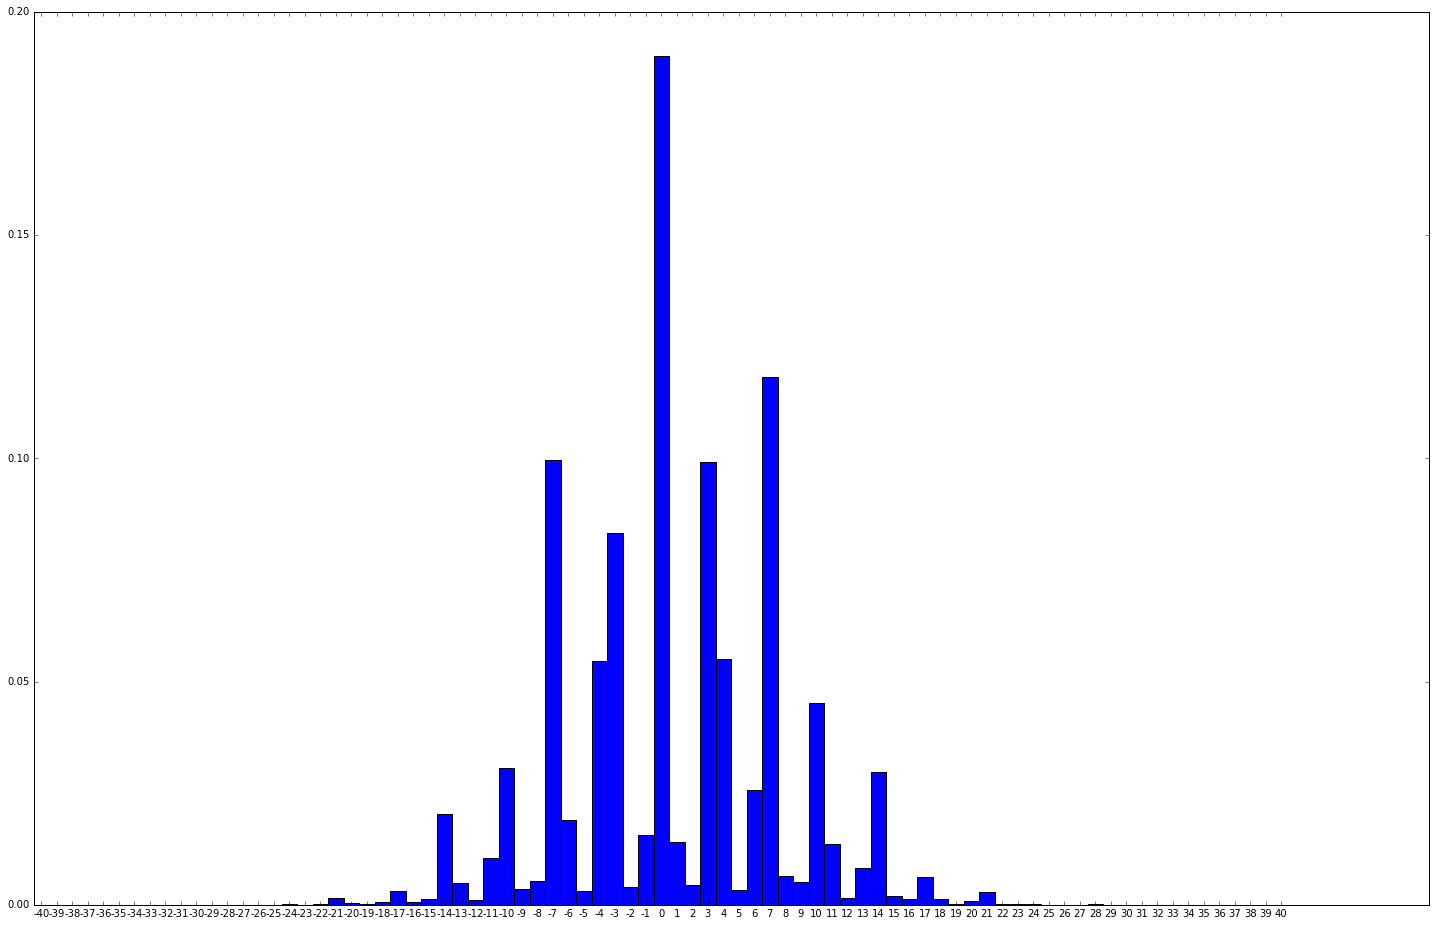

In [153]:
pdf = predicted_score_difference((1, 1, 1, 0), 43)
score_diff = []
probability = []
smallest = sorted(pdf.items())[0][0]
largest = sorted(pdf.items())[-1][0]
print(smallest, largest)
for s in range(-40, 41):
    p = pdf[s]
    score_diff.append(s)
    probability.append(p)
pylab.rcParams['figure.figsize'] = (25.0, 16.0)
indexes = np.arange(len(score_diff))
width = 1

plt.bar(indexes, probability, width)
plt.xticks(indexes + width * 0.5, score_diff)
plt.show()

In [154]:
p2 = [0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 8.590913049238271e-08,
 5.0368203818119676e-08,
 0.0,
 1.5711050756106297e-08,
 2.548633682137432e-07,
 2.6705686233336825e-07,
 2.2177029473051696e-06,
 2.037014604185237e-05,
 9.296077812488939e-06,
 1.5850385583882454e-06,
 6.277214890443037e-06,
 5.011779136713652e-05,
 2.3572892652339315e-05,
 0.00010405134611239556,
 0.001239967044119184,
 0.00037407134633000994,
 6.821197429555011e-05,
 0.0004495251651954358,
 0.0026115492896615776,
 0.0005797023174168079,
 0.001137845216986586,
 0.019016131121245405,
 0.004453014910757983,
 0.0009608433304050931,
 0.010186653540399855,
 0.029217967145849514,
 0.003118157385082037,
 0.004712402539546323,
 0.08921577953533989,
 0.017702187046593078,
 0.0030762228689117485,
 0.058551314514242815,
 0.07531590013439553,
 0.003827710712997583,
 0.017395923425741425,
 0.17108356029438385,
 0.014171072690631397,
 0.00496711010842484,
 0.10213584975602819,
 0.05876123514674941,
 0.003581810351036449,
 0.03014598223630368,
 0.12043584073974453,
 0.006401019994826536,
 0.0061579744404007385,
 0.05581803490536087,
 0.015448034944679443,
 0.0018260290038738262,
 0.010416756617782911,
 0.03608635802669192,
 0.0022258365342286844,
 0.0016184951918991543,
 0.008202853469914815,
 0.0011983751882454657,
 0.0002042244313135899,
 0.0010939697642543282,
 0.0037435135945758017,
 0.0003172356907138771,
 9.948837804318133e-05,
 0.00024561785569479324,
 2.8044164508722404e-05,
 6.822311534540335e-06,
 3.960782358468145e-05,
 9.450511810154042e-05,
 1.0376668501719334e-05,
 1.5622343689044508e-06,
 1.7725786993998285e-06,
 2.0078199436476908e-07,
 6.761828914708405e-08,
 3.7279793340999653e-07,
 6.115440315199974e-07,
 7.386088970538335e-08,
 0.0,
 0.0,
 0.0,
 0.0]

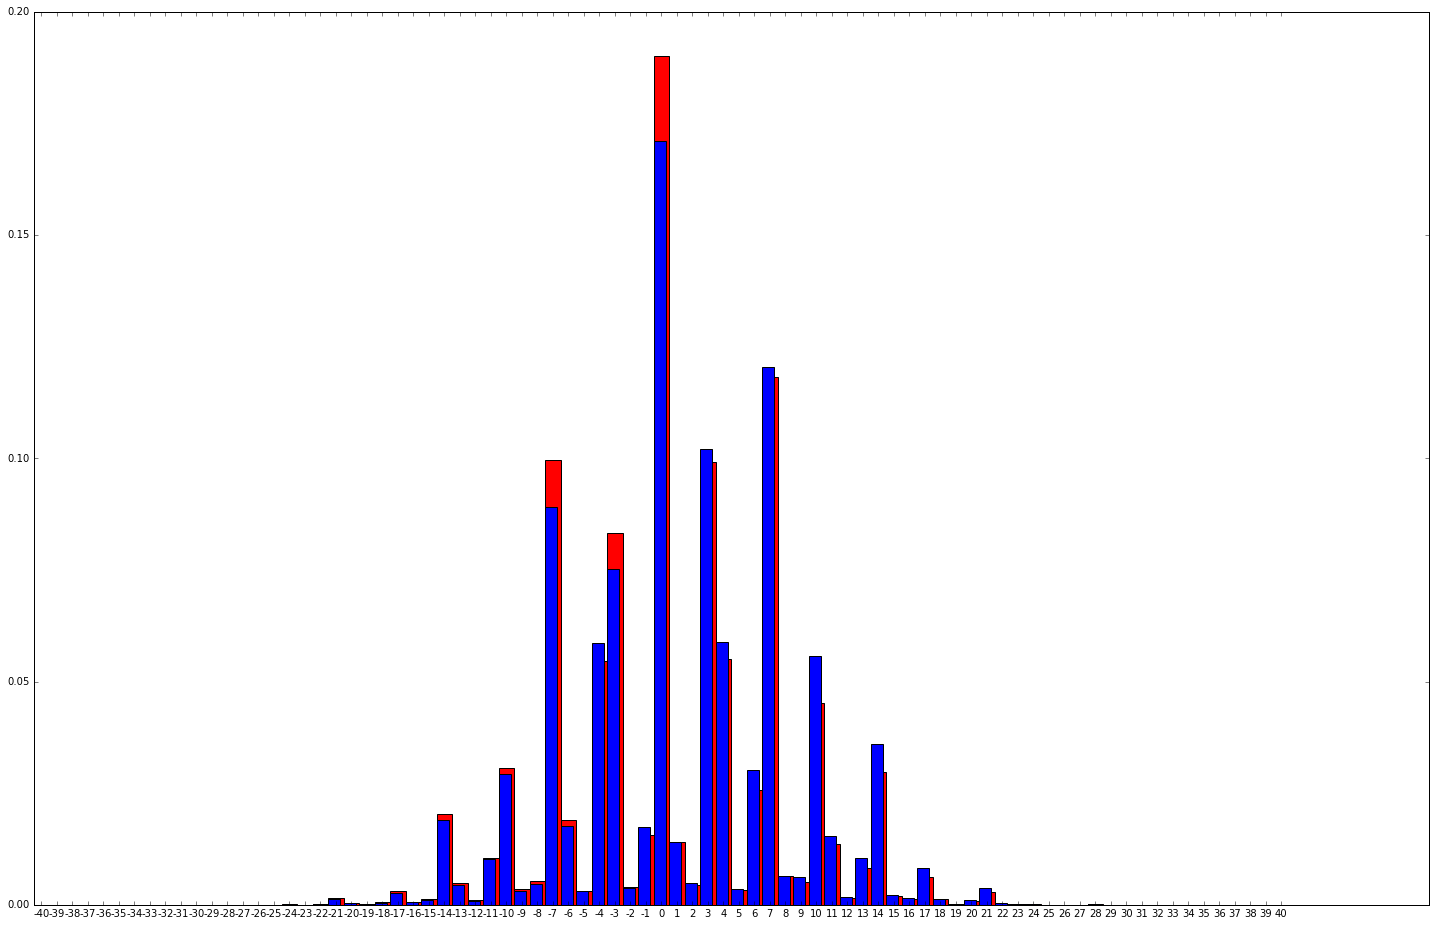

In [155]:

indexes = np.arange(len(score_diff))
width = 1

plt.bar(indexes, probability, width, color = 'r')
plt.bar(indexes, p2)
plt.xticks(indexes + width * 0.5, score_diff)
plt.show()

In [156]:
sum(pdf.values())

0.9999995507112044

In [157]:
sum(p2)

0.9999995395427517

In [158]:
sum(probability)

0.9999995507112046

In [159]:
math.exp(-3.0391177576866233)

0.0478771100794207

In [160]:
math.exp(-3.0165102195221607)

0.048971821411601744

In [161]:
test_data[0]

{'def': 'a',
 'def_team_avg_yards': 4.0,
 'down': 1,
 'final_diff': -6,
 'off': 'a',
 'off_team_avg_yards': 5.590909090909091,
 'third_diff': -6,
 'togo': 10,
 'yard_line': 18,
 'ydline': 18}

In [162]:
score_diff_counts = collections.Counter()
for game in test_data:
    if game['down'] != -1:
        score_diff_counts[game['final_diff'] - game['third_diff']] += 1

In [163]:
sum(score_diff_counts.values())

291

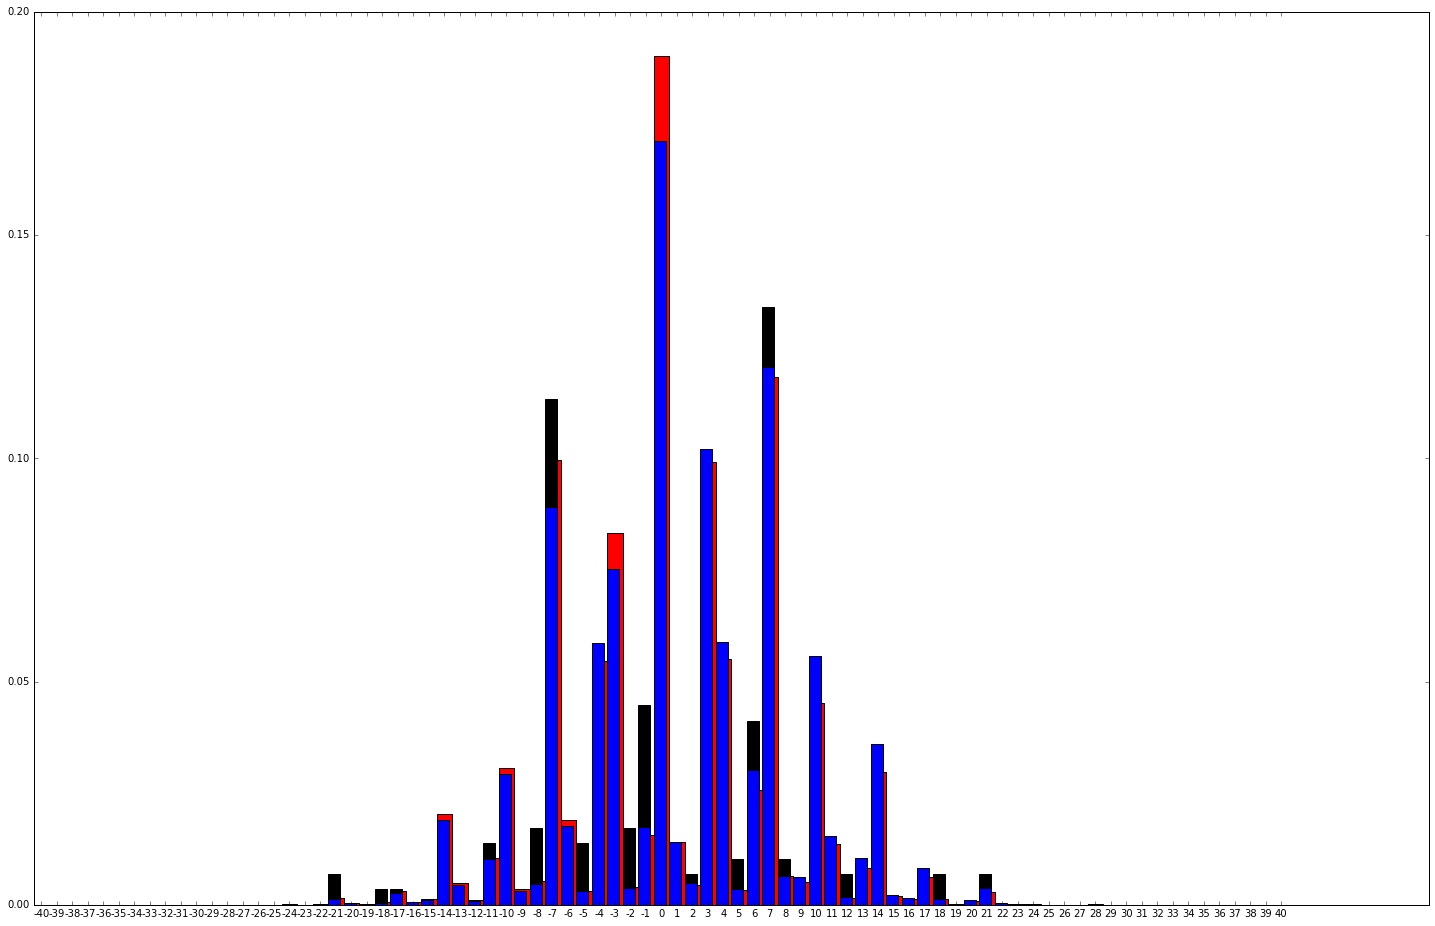

In [164]:
p3 = []
for i in range(-40, 41):
    p3.append(score_diff_counts[i] / sum(score_diff_counts.values()))
indexes = np.arange(len(score_diff))
width = 1

plt.bar(indexes, probability, width, color = 'r')
plt.bar(indexes, p3, color = 'k')
plt.bar(indexes, p2, color = 'b')
plt.xticks(indexes + width * 0.5, score_diff)
plt.show()

In [165]:
p3[40]

0.14776632302405499